The following tutorials are available from the [Wallaroo Tutorials Repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/tree/main/notebooks_in_prod).

# Stage 1: Data Exploration And Model Selection

When starting a project, the data scientist focuses on exploration and experimentation, rather than turning the process into an immediate production system.  This notebook presents a simplified view of this stage.

## Resources

The following resources are used as part of this tutorial:

* **data**
  * `data/seattle_housing_col_description.txt`: Describes the columns used as part data analysis.
  * `data/seattle_housing.csv`: Sample data of the Seattle, Washington housing market between 2014 and 2015.
* **code**
  * `postprocess.py`: Formats the data after inference by the model is complete.
  * `preprocess.py`: Formats the incoming data for the model.
  * `simdb.py`: A simulated database to demonstrate sending and receiving queries.
  * `wallaroo_client.py`: Additional methods used with the Wallaroo instance to create workspaces, etc.

## Steps

The following steps are part of this process:

* [Retrieve Training Data](#retrieve-training-data): Connect to the data store and retrieve the training data.
* [Data Transformations](#data-transformations): Evaluate the data and train the model.
* [Model Testing](#model-testing): Evaluate different models and determine which is best suited for the problem.

### Import Libraries

First we'll import the libraries we'll be using to evaluate the data and test different models.

In [2]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.ensemble

import xgboost as xgb

import seaborn
import matplotlib
import matplotlib.pyplot as plt

import simdb # module for the purpose of this demo to simulate pulling data from a database

matplotlib.rcParams["figure.figsize"] = (12,6)

# ignoring warnings for demonstration
import warnings
warnings.filterwarnings('ignore')

### Retrieve Training Data

For training, we will use the data on all houses sold in this market with the last two years.  As a reminder, this data pulled from a simulated database as an example of how to pull from an existing data store.

Only a few columns will be shown for display purposes.

In [3]:
conn = simdb.simulate_db_connection()
tablename = simdb.tablename

query = f"select * from {tablename} where date > DATE(DATE(), '-24 month') AND sale_price is not NULL"
print(query)
# read in the data
housing_data = pd.read_sql_query(query, conn)

conn.close()
housing_data.loc[:, ["id", "date", "list_price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot"]]

select * from house_listings where date > DATE(DATE(), '-24 month') AND sale_price is not NULL


,id,date,list_price,bedrooms,bathrooms,sqft_living,sqft_lot
0,7129300520,2022-10-05,221900.0,3,1.00,1180,5650
1,6414100192,2022-12-01,538000.0,3,2.25,2570,7242
2,5631500400,2023-02-17,180000.0,2,1.00,770,10000
3,2487200875,2022-12-01,604000.0,4,3.00,1960,5000
4,1954400510,2023-02-10,510000.0,3,2.00,1680,8080
...,...,...,...,...,...,...,...
20518,263000018,2022-05-13,360000.0,3,2.50,1530,1131
20519,6600060120,2023-02-15,400000.0,4,2.50,2310,5813
20520,1523300141,2022-06-15,402101.0,2,0.75,1020,1350
20521,291310100,2023-01-08,400000.0,3,2.50,1600,2388


### Data transformations

To improve relative error performance, we will predict on `log10` of the sale price.

Predict on log10 price to try to improve relative error performance

In [19]:
housing_data['logprice'] = np.log10(housing_data.sale_price)

From the data, we will create the following features to evaluate:

* `house_age`: How old the house is.
* `renovated`: Whether the house has been renovated or not.
* `yrs_since_reno`: If the house has been renovated, how long has it been.

In [20]:
import datetime

thisyear = datetime.datetime.now().year

housing_data['house_age'] = thisyear - housing_data['yr_built']
housing_data['renovated'] =  np.where((housing_data['yr_renovated'] > 0), 1, 0) 
housing_data['yrs_since_reno'] =  np.where(housing_data['renovated'], housing_data['yr_renovated'] - housing_data['yr_built'], 0)

housing_data.loc[:, ['yr_built', 'yr_renovated', 'house_age', 'renovated', 'yrs_since_reno']]



,yr_built,yr_renovated,house_age,renovated,yrs_since_reno
0,1955,0,68,0,0
1,1951,1991,72,1,40
2,1933,0,90,0,0
3,1965,0,58,0,0
4,1987,0,36,0,0
...,...,...,...,...,...
20518,2009,0,14,0,0
20519,2014,0,9,0,0
20520,2009,0,14,0,0
20521,2004,0,19,0,0


Now we pick variables and split training data into training and holdout (test).

In [21]:
vars = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'house_age', 'renovated', 'yrs_since_reno']

outcome = 'logprice'

runif = np.random.default_rng(2206222).uniform(0, 1, housing_data.shape[0])
gp = np.where(runif < 0.2, 'test', 'training')

hd_train = housing_data.loc[gp=='training', :].reset_index(drop=True, inplace=False)
hd_test = housing_data.loc[gp=='test', :].reset_index(drop=True, inplace=False)


# split the training into training and val for xgboost
runif = np.random.default_rng(123).uniform(0, 1, hd_train.shape[0])
xgb_gp = np.where(runif < 0.2, 'val', 'train')


In [22]:
# for xgboost, further split into train and val
train_features = np.array(hd_train.loc[xgb_gp=='train', vars])
train_labels = np.array(hd_train.loc[xgb_gp=='train', outcome])

val_features = np.array(hd_train.loc[xgb_gp=='val', vars])
val_labels = np.array(hd_train.loc[xgb_gp=='val', outcome])


#### Postprocessing

Since we are fitting a model to predict `log10` price, we need to convert predictions back into price units. We also want to round to the nearest dollar.

In [23]:
def postprocess(log10price):
    return np.rint(np.power(10, log10price))

### Model testing

For the purposes of this demo, let's say that we require a mean absolute percent error (MAPE) of 15% or less, and the we want to try a few models to decide which model we want to use.

One could also hyperparameter tune at this stage; for brevity, we'll omit that in this demo.

#### XGBoost

First we will test out using a XGBoost model.

In [24]:

xgb_model = xgb.XGBRegressor(
    objective = 'reg:squarederror', 
    max_depth=5, 
    base_score = np.mean(hd_train[outcome])
    )

xgb_model.fit( 
    train_features,
    train_labels,
    eval_set=[(train_features, train_labels), (val_features, val_labels)],
    verbose=False,
    early_stopping_rounds=35
)


XGBRegressor(base_score=5.666446833601829, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [25]:
print(xgb_model.best_score)
print(xgb_model.best_iteration)
print(xgb_model.best_ntree_limit)

0.07793614689092423
99
100


#### XGBoost Evaluate on holdout

With the sample model created, we will test it against the holdout data.  Note that we are calling the `postprocess` function on the data.

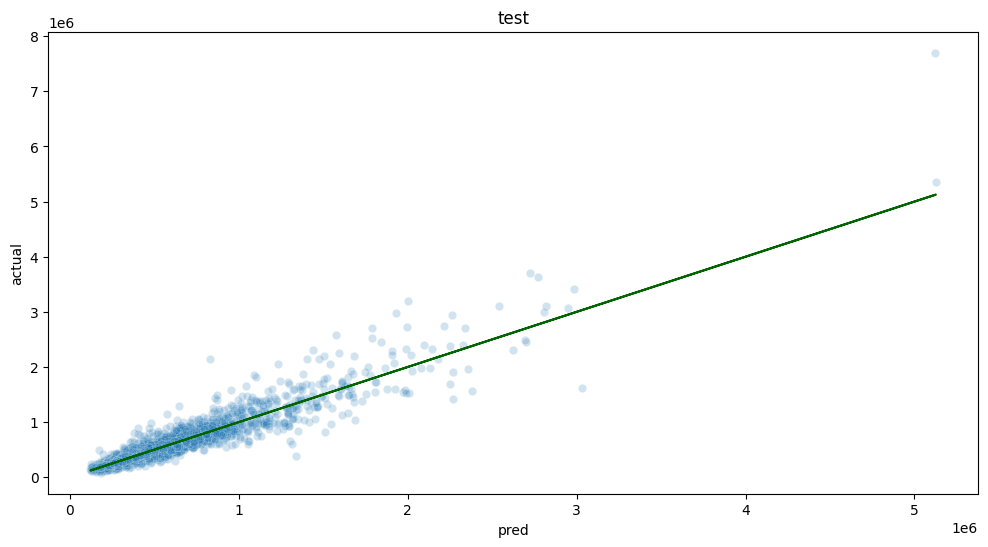

In [26]:
test_features = np.array(hd_test.loc[:, vars])
test_labels = np.array(hd_test.loc[:, outcome])

pframe = pd.DataFrame({
    'pred' : postprocess(xgb_model.predict(test_features)),
    'actual' : postprocess(test_labels)
})

ax = seaborn.scatterplot(
    data=pframe,
    x='pred',
    y='actual',
    alpha=0.2
)
matplotlib.pyplot.plot(pframe.pred, pframe.pred, color='DarkGreen')
matplotlib.pyplot.title("test")
plt.show()

In [27]:
pframe['se'] = (pframe.pred - pframe.actual)**2

pframe['pct_err'] = 100*np.abs(pframe.pred - pframe.actual)/pframe.actual
pframe.describe()

,pred,actual,se,pct_err
count,4.094000e+03,4.094000e+03,4.094000e+03,4094.000000
mean,5.340824e+05,5.396937e+05,1.657722e+10,12.857674
std,3.413714e+05,3.761666e+05,1.276017e+11,13.512028
min,1.216140e+05,8.200000e+04,1.000000e+00,0.000500
25%,3.167628e+05,3.200000e+05,3.245312e+08,4.252492
50%,4.568700e+05,4.500000e+05,1.602001e+09,9.101485
75%,6.310372e+05,6.355250e+05,6.575385e+09,17.041227
max,5.126706e+06,7.700000e+06,6.637466e+12,252.097895


In [28]:
rmse = np.sqrt(np.mean(pframe.se))
mape = np.mean(pframe.pct_err)

print(f'rmse = {rmse}, mape = {mape}')

rmse = 128752.54982046234, mape = 12.857674005250548


#### Random Forest

The next model to test is Random Forest.

In [29]:
model_rf = sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=2, max_samples=0.8)

train_features = np.array(hd_train.loc[:, vars])
train_labels = np.array(hd_train.loc[:, outcome])

model_rf.fit(train_features, train_labels)

RandomForestRegressor(max_depth=5, max_samples=0.8, n_jobs=2)

#### Random Forest Evaluate on holdout

With the Random Forest sample model created, now we can test it against the holdout data.

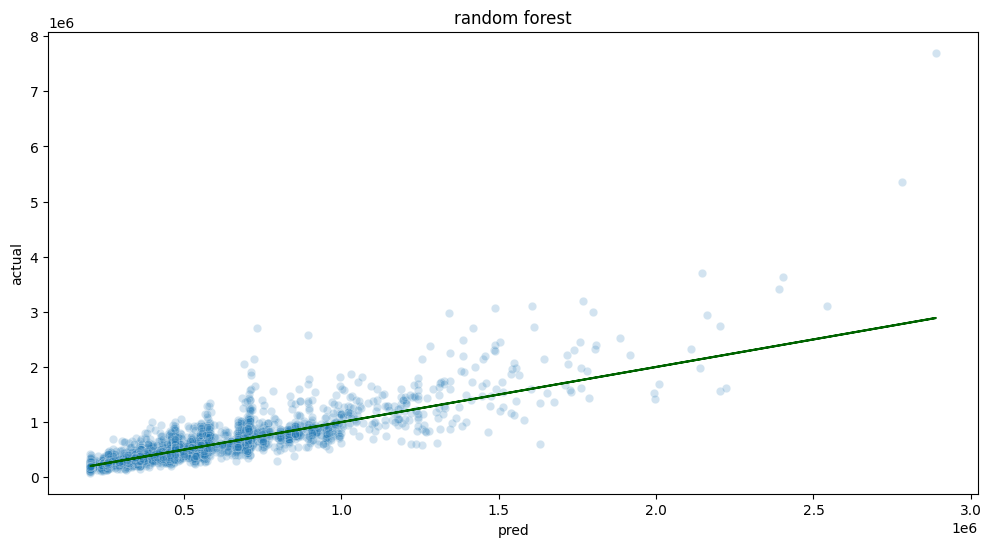

In [30]:
pframe = pd.DataFrame({
    'pred' : postprocess(model_rf.predict(test_features)),
    'actual' : postprocess(test_labels)
})

ax = seaborn.scatterplot(
    data=pframe,
    x='pred',
    y='actual',
    alpha=0.2
)
matplotlib.pyplot.plot(pframe.pred, pframe.pred, color='DarkGreen')
matplotlib.pyplot.title("random forest")
plt.show()

In [31]:
pframe['se'] = (pframe.pred - pframe.actual)**2

pframe['pct_err'] = 100*np.abs(pframe.pred - pframe.actual)/pframe.actual
pframe.describe()

,pred,actual,se,pct_err
count,4.094000e+03,4.094000e+03,4.094000e+03,4094.000000
mean,5.194535e+05,5.396937e+05,3.875433e+10,18.188652
std,2.797001e+05,3.761666e+05,4.054895e+11,17.634478
min,2.039200e+05,8.200000e+04,1.444000e+03,0.014729
25%,3.291252e+05,3.200000e+05,6.686879e+08,6.156760
50%,4.621880e+05,4.500000e+05,3.321332e+09,13.148593
75%,5.851052e+05,6.355250e+05,1.367023e+10,24.630187
max,2.888692e+06,7.700000e+06,2.314868e+13,175.444819


In [32]:
rmse = np.sqrt(np.mean(pframe.se))
mape = np.mean(pframe.pct_err)

print(f'rmse = {rmse}, mape = {mape}')

rmse = 196861.19318381665, mape = 18.188652142429135


### Final Decision

At this stage, we decide to go with the **xgboost** model, with the variables/settings above.

With this stage complete, we can move on to Stage 2: Training Process Automation Setup.